<a href="https://colab.research.google.com/github/AlfAnalyst/study-projects-data-science-and-analysis/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%BE%D1%82%D0%B7%D1%8B%D0%B2%D0%BE%D0%B2_%D0%BD%D0%B0_%D0%BF%D0%BE%D0%BB%D0%BE%D0%B6%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%B8_%D0%BE%D1%82%D1%80%D0%B8%D1%86%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задача:

В данном задании ставится задача по распознаванию позитивных и негативных отзывы людей по автомобилю Tesla. База для обучения содержит два текстовых файла с рядом строчных отзывов с мнением людей об автомобиле Tesla, соответственно негативного и позитивного содержания. 

Необходимо выполнить следующие действия:

  1. Загрузите саму базу по ссылке и подговьте файлы базы для обработки.
  2. Создайте обучающую и проверочную выборки, обратив особое внимание на балансировку базы: количество примеров каждого класса должно быть примерно одного порядка.
  3. Подготовьте выборки для обучения и обучите сеть. Добейтесь результата точности сети в 85-90% на проверочной выборке.
   


**Импорт библиотек, загрузка базы и подготовка её к предобработке.**

In [ ]:
import os                                                                       # Для работы с файлами.
import gdown                                                                    # Для работы с файлами.
import pandas as pd                                                             # Для работы с таблицами.
import numpy as np                                                              # Для работы с массивами.
import matplotlib.pyplot as plt                                                 # Для отрисовки графиков.                                             
%matplotlib inline

from tensorflow.keras import utils                                              # Для работы с категориальными данными.
from tensorflow.keras.models import Sequential                                  # Полносвязная модель.
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization          # Слои для нейросети.
from tensorflow.keras.layers import SpatialDropout1D, Flatten, Embedding        # Слои для нейросети.
from tensorflow.keras.preprocessing.text import Tokenizer                       # Методы для работы с текстами и преобразования их в последовательности.

from sklearn.metrics import confusion_matrix                                    # Матрицы ошибок классификатора.
from sklearn.preprocessing import LabelEncoder                                  # Метод кодирования тестовых лейблов.
from sklearn.model_selection import train_test_split                            # Для разделения выборки на тестовую и обучающую.

from seaborn import set_style                                                   # Сетка для графиков.
set_style('darkgrid')

In [ ]:
gdown.download('tesla.zip', None, quiet=True)

'tesla.zip'

**Деление общей базы отзывов на данные для обучения и проверки.**

In [ ]:
# Распаковка архива в папку writers
!unzip -qo tesla.zip -d tesla/

# Просмотр содержимого папки
!ls tesla

'Негативный отзыв.txt'	'Позитивный отзыв.txt'


**Загрузка текста из файлов, преобразование в одну строку.**

In [ ]:
# Объявляем функции для чтения файла. На вход отправляем путь к файлу
def read_text(file_name):

  # Задаем открытие нужного файла в режиме чтения              
  read_file = open(file_name, 'r')

  # Читаем текст     
  text = read_file.read()

  # Переносы строки переводим в пробелы              
  text = text.replace("\n", " ")

  # Возвращаем текст файла       
  return text                          

# Объявляем интересующие нас классы
class_names = ["Негативный отзыв", "Позитивный отзыв"]

# Считаем количество классов 
class_count = len(class_names)
print(f'Количество классов: {class_count}')

Количество классов: 2


**Тексты в один список.**

In [ ]:
# Создаём список под тексты для обучающей выборки
texts_list = []

# Циклом проводим итерацию по текстовым файлам в папке отзывов
for j in os.listdir('/content/tesla/'):

  # Добавляем каждый файл в общий список для выборки
        texts_list.append(read_text('/content/tesla/' + j))
        
        # Выводим на экран сообщение о добавлении файла
        print(j, 'добавлен в обучающую выборку')

Позитивный отзыв.txt добавлен в обучающую выборку
Негативный отзыв.txt добавлен в обучающую выборку


In [ ]:
# Узнаем объём каждого текста в словах и символах
texts_len = [len(text) for text in texts_list]

# Устанавливаем "счётчик" номера текста
t_num = 0

# Выводим на экран  информационное сообщение
print(f'Размеры текстов по порядку (в токенах):')

# Циклом проводим итерацию по списку с объёмами текстов
for text_len in texts_len:

  # Запускаем "счётчик" номера текста
  t_num += 1
  
  # Выводим на экран сообщение о номере и объёме текста
  print(f'Текст №{t_num}: {text_len}')

Размеры текстов по порядку (в токенах):
Текст №1: 213381
Текст №2: 134535


Далее рассчитаем, сколько символов составит 80% объёма каждого текста, чтобы по полученному индексу отделить эти 80% на обучающую и оставшиеся 20% на проверочную выборку. Эти значения необходимы для подготовки деления на выборки слайсингом по индексу.

In [ ]:
# Создаём список с вложенным циклом по длинам текстов, где i - 100% текста, i/5 - 20% текста 
train_len_shares = [(i - round(i/5)) for i in texts_len]

# Устанавливаем "счётчик" номера текста
t_num = 0

# Циклом проводим итерацию по списку с объёмами текстов равными 80% от исходных
for train_len_share in train_len_shares:

  # Запускаем "счётчик" номера текста
  t_num += 1
  
  # Выводим на экран сообщение о номере и объёме текста в 80% от исходного
  print(f'Доля 80% от текста №{t_num}: {train_len_share} символов')

In [ ]:
file_dir = '/content/tesla/'                                                    # Папка с файлами отзывов.

In [ ]:
# Подготовим пустые списки.
class_list = []                                                                 # Список классов.
fb_train = []                                                                   # Обучающая выборка.
fb_test = []                                                                    # Тестовая выборка.

coef_split = 0.8                                                                # Коэффициент разделения на обучающую и тестовую выборки.

file_list = sorted(os.listdir(file_dir))                                        # Список файлов в папке tesla.

for file1 in file_list:
  m = file1.split('.')                                                          # Разделяем имя файла и расширение.
  cls_name = m[0]                                                               # Имя файла(класса).

  if file1:
    if cls_name not in class_list:                                              # Если имени нет в списке классов
      print(f'Добавление класса "{cls_name}"')               
      class_list.append(cls_name)                                               # добавим класс в список.

    cls = class_list.index(cls_name)                                            # Номер нового класса.
    print(f'Добавление файла "{file1}" в класс "{class_list[cls]}"')     

    with open(f'{file_dir}/{file1}', 'r') as f:                                 # Открываем файл для чтения.
      text = f.read()                                                           # Загружаем файл в строку.
      text = text.replace('\n', ' ').split(' ')                                 # Заменяем символы перевода строки на пробелы.
      text_len = len(text)                                                      # Количество слов.
      fb_train.append(' '.join(text[:int(text_len * coef_split)]))              # Текст для обучающей выборки.
      fb_test.append(' '.join(text[int(text_len * coef_split):]))               # Текст для проверочной выборки.

Добавление класса "Негативный отзыв"
Добавление файла "Негативный отзыв.txt" в класс "Негативный отзыв"
Добавление класса "Позитивный отзыв"
Добавление файла "Позитивный отзыв.txt" в класс "Позитивный отзыв"


In [ ]:
class_count = len(class_list)                                                   # Посмотрим на количество классов.
print(f'Количество классов: {class_count}')

Количество классов: 2


In [ ]:
# Посмотрим на получившиеся выборки.
for cls in range(class_count):
  print(f'Класс: {class_list[cls]}')
  print(f'~~ train: {fb_train[cls]}')
  print(f'~~  test: {fb_test[cls]}')
  print()

Класс: Негативный отзыв
~~ train: После 170 на трассе она чувствует себя неуверенно.  Кстати сидения очень удобными тоже не назовёшь. ... Это моё личное впечатление об автомобиле. Шляпа, а не авто, все не продумано до мелочей. Пока это гаджет а не авто. Это не авто, а бренд. Стремнные материалы, стремно все. Прям фу фу фу и дизайн снаружи и внутри. Продал  слава богу, экран менять целое дело через полтора года , негодование обычно возникает из-за несостоявшихся обманутых ожиданий. Не нужно воспринимать теслу как эталон, верх совершенства и т.п. Относитесь к тесле как гаджету и тогда не будет несбывшихся ожиданий от него гаджету можно простить и заоблачную цену при скромных характеристиках и зазоры на дверях при выдвигающихся ручках дверей. Походу ещё один бот и видите как тезисы выкидывает не нужно воспринимать Теслу как эталон, Тесла это гаджет, который нет смысла покупать...  Как я уже и писал к предыдущему посту КАЧЕСТВО СБОРКИ ХРОМАЕТ! Я пару дней назад указал на не совсем качестве

In [ ]:
# Обработка текстовых данных.

max_words_count = 10000                                                         # Количество слов используемое нейросетью для обучения.

filters = '!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff'                 # Ненужные символы.

oov_token = 'неведомое слово'

# Преобразуем текст в матрицу цифровых значений.
tokenizer = Tokenizer(num_words=max_words_count, filters=filters, lower=True, char_level=False, oov_token=oov_token)

tokenizer.fit_on_texts(fb_train)                                                # Собираем словарь частотности.

# Преобразуем тексты в индексы.
train_seq = tokenizer.texts_to_sequences(fb_train)
test_seq = tokenizer.texts_to_sequences(fb_test)

# Посмотрим на размер словаря.
items = list(tokenizer.word_index.items())
print(f'Размер словаря: {len(items)}')

Размер словаря: 10384


In [ ]:
# Посмотрим на статистику собранных слов.
for cls in range(len(class_list)):
  print(f'{class_list[cls]} : {len(train_seq[cls])} слов.')

Негативный отзыв : 17049 слов.
Позитивный отзыв : 25906 слов.


In [ ]:
# Функция разбиения последовательности на отрезки скользящим окном.
def split_sequence(sequence, win_size, step):
  return [sequence[i : i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

In [ ]:
# Функция формирования выборок из последовательностей.
def vectorize_sequence(seq_list, win_size, step):
  cls_count = len(seq_list)

  x, y = [], []                                                                 # Пустые списки для выборок.

  for cls in range(cls_count):
    vectors = split_sequence(seq_list[cls], win_size, step)                     # Разбиваем последовательность на отрезки.

    x += vectors                                                                # Добавляем отрезки в выборку.
    y += [utils.to_categorical(cls, cls_count)] * len(vectors)                  # Добавляем соответствующие метки класса в виде ont hot encoding.

  return np.array(x), np.array(y)                                               # Выводим результаты в виде numpy-массива.

In [ ]:
# Формируем обучающую и тестовую выборку.
win_size = 1000                                                                 # Длина отрезка текста в словах.
step = 100                                                                      # Шаг смещения по тексту.

In [ ]:
# Создаем обучающую выборку.
x_train, y_train = vectorize_sequence(train_seq, win_size, step)
print(f'Размерности обучающей выборки: {x_train.shape} и {y_train.shape}')

Размерности обучающей выборки: (411, 1000) и (411, 2)


In [ ]:
# Создаем тестовую выборку.
x_test, y_test = vectorize_sequence(test_seq, win_size,step)
print(f'Размерности тестовой выборки: {x_test.shape} и {y_test.shape}')

Размерности тестовой выборки: (88, 1000) и (88, 2)


In [ ]:
# Создаем обучающую и тестовую выборки в виде матриц Bag of Words.
x_train0 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test0 = tokenizer.sequences_to_matrix(x_test.tolist())

In [ ]:
# Функция компиляции модели и построения графиков.
def compile_model(model, x_train, y_train, x_val, y_val, epochs, batch_size):

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=1)

  val_acc = round(history.history['val_accuracy'][-1], 3) * 100
  print()
  print(f'Точность на проверочной выборке на последней эпохе: {val_acc}%')
  print()

  # Вывод графиков.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
  
  ax1.plot(history.history['accuracy'], label='Доля верных ответов на обучающей выборке.')
  ax1.plot(history.history['val_accuracy'], label='Доля верных ответов на тестовой выборке.')
  ax1.set_xlabel('Эпохи обучения.')
  ax1.set_ylabel('Доля верных ответов.')
  ax1.legend()

  ax2.plot(history.history['loss'], label='Ошибка на обучающей выборке.')
  ax2.plot(history.history['val_loss'], label='Ошибка на проверочной выборке.')
  ax2.set_xlabel('')
  ax2.set_ylabel('')
  
  plt.show()

## Модель №1.

In [ ]:
batch_size1 = 16
epochs1 = 2

In [ ]:
model1 = Sequential()                                                           #Создаем модель.

model1.add(Dense(80, input_dim=max_words_count, activation='relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())

model1.add(Dense(class_count, activation='softmax'))


In [ ]:
model1.summary()                                                                # Выводим структуру модели.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 80)                800080    
                                                                 
 dropout_4 (Dropout)         (None, 80)                0         
                                                                 
 batch_normalization_4 (Batc  (None, 80)               320       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 2)                 162       
                                                                 
Total params: 800,562
Trainable params: 800,402
Non-trainable params: 160
_________________________________________________________________


Epoch 1/2
26/26 [==============================] - 1s 11ms/step - loss: 0.1112 - accuracy: 0.9562 - val_loss: 0.2075 - val_accuracy: 0.9773
Epoch 2/2
26/26 [==============================] - 0s 5ms/step - loss: 0.0212 - accuracy: 0.9903 - val_loss: 0.1132 - val_accuracy: 1.0000

Точность на проверочной выборке на последней эпохе: 100.0%



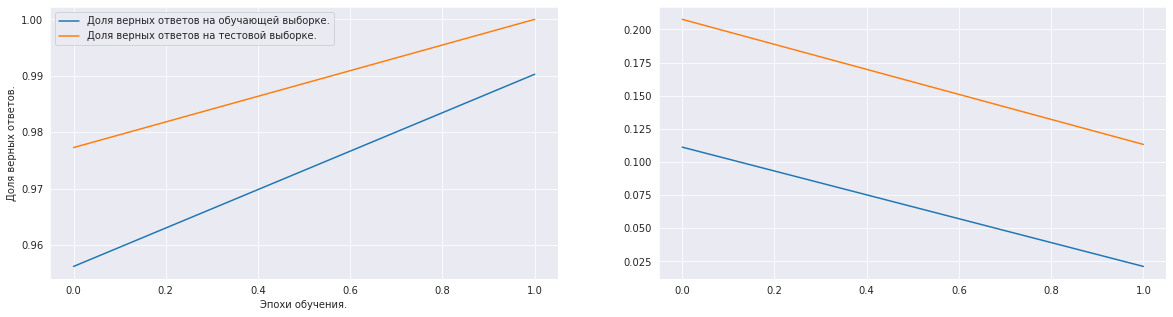

In [ ]:
compile_model(model1, x_train0, y_train, x_test0, y_test, epochs1, batch_size1)

С использованием метода Bag of Words на простой модели была достигнута точность на проверочной выборке 100%.